In [663]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [664]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [665]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

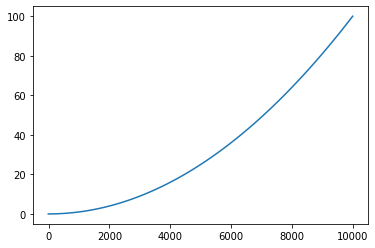

In [666]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x/1000)**2

x = torch.linspace(-10, 100*100)
plt.plot(x, area_cost(x))

# Detector panels

In [667]:
c = torch.tensor([0.5,0.5], requires_grad=True)
s = torch.tensor([0.5,1], requires_grad=True)

In [668]:
gauss = torch.distributions.Normal(c, s)

In [669]:
torch.prod(torch.exp(gauss.log_prob(Tensor([[0.5,0.5], [1,1]])))/torch.exp(gauss.log_prob(Tensor([0.5,0.5]))),dim=-1)

tensor([1.0000, 0.5353], grad_fn=<ProdBackward1>)

In [729]:
class DetectorPanel(nn.Module):
    def __init__(
        self,
        res: float,
        eff: float,
        init_xyz:Tuple[float,float,float],
        init_xy_span: Tuple[float,float],
        area_cost_func: Callable[[Tensor], Tensor],
        device: torch.device = DEVICE
    ):
        if res <= 0:
            raise ValueError(f'Resolution must be positive')
        if eff <= 0:
            raise ValueError(f'Efficiency must be positive')
            
        super().__init__()
        self.area_cost_func, self.device = area_cost_func, device
        self.register_buffer('resolution', torch.tensor(float(res), requires_grad=True, device=self.device))
        self.register_buffer('efficiency', torch.tensor(float(eff), requires_grad=True, device=self.device))
        self.xyz = nn.Parameter(torch.tensor(init_xyz, device=self.device))
        self.xy_span = nn.Parameter(torch.tensor(init_xy_span, device=self.device))
        
    def __repr__(self) -> str:
        return f'''{self.__class__} located at {self.xyz.data}, and xy span {self.xy_span}'''
    
    def get_xy_mask(self, xy: Tensor) -> Tensor:
        xy_low = self.xy-(self.xy_span/2)
        xy_high = self.xy+(self.xy_span/2)
        return (xy[:,0] >= xy_low[0]) * (xy[:,0] < xy_high[0]) * (xy[:,1] >= xy_low[1]) * (xy[:,1] < xy_high[1])
    
    def get_resolution(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            res = self.resolution*torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            res = torch.zeros((len(xy),2), device=self.device)  # Zero detection outside detector
            res[mask] = self.resolution
        return res
    
    def get_efficiency(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            scale = torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
            eff = self.efficiency*torch.prod(scale, dim=-1)  # Maybe weight product by xy distance?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            eff = torch.zeros(len(xy), device=self.device)  # Zero detection outside detector
            eff[mask] = self.efficiency
        return eff
        
    def get_hits(self, mu: MuonBatch) -> Dict[str, Tensor]:
        mask = mu.get_xy_mask(self.xy-(self.xy_span/2), self.xy+(self.xy_span/2))  # Muons in panel
        
        xy0 = self.xy-(self.xy_span/2)  # Low-left of voxel
        rel_xy = mu.xy - xy0
        res = self.get_resolution(mu.xy, mask)        
        rel_xy = rel_xy + (torch.randn((len(mu), 2), device=self.device) / res)
        
        if not self.training:  # Prevent reco hit from exiting panel
            span = self.xy_span.detach().cpu().numpy()
            rel_xy[mask] = torch.stack([torch.clamp(rel_xy[mask][:,0], 0, span[0]),
                                        torch.clamp(rel_xy[mask][:,1], 0, span[1])], dim=-1)  
        reco_xy = xy0 + rel_xy

        hits = {
            "reco_xy": reco_xy,
            "gen_xy": mu.xy.detach().clone(),
            "z": self.z.expand_as(mu.x)[:, None],
        }
        return hits

    def get_cost(self) -> Tensor:
        return self.area_cost_func(self.xy_span.prod())
    
    @property
    def xy(self) -> Tensor:
        return self.xyz[:2]
    
    @property
    def z(self) -> Tensor:
        return self.xyz[2]

In [730]:
from tomopt.volume.layer import Layer

class DetectorLayer(Layer):
    def __init__(
        self,
        pos: str,
        lw: Tensor,
        z: float,
        size: float,
        panels: nn.ModuleList,
        device: torch.device = DEVICE,
    ):
        super().__init__(lw=lw, z=z, size=size, device=device)
        if isinstance(panels, list):
            panels = nn.ModuleList(panels)
        self.pos, self.panels = pos, panels
    
    def get_panel_zorder(self) -> List[int]:
        return np.argsort([p.z.detach().cpu().item() for p in self.panels])[::-1]
        
    def check_panels(self) -> None:
        with torch.no_grad(): 
            for p in self.panels:
                torch.clamp_(p.z, min=self.z.detach().cpu()[0]-self.size, max=self.z.detach().cpu()[0])

    def forward(self, mu: MuonBatch) -> None:
        self.check_panels()
        for i in self.get_panel_zorder():
            self.scatter_and_propagate(mu, mu.z-self.panels[i].z)  # Move to panel
            mu.append_hits(self.panels[i].get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, mu.z-(self.z-self.size))  # Move to bottom of layer

    def get_cost(self) -> Tensor:
        for i, p in enumerate(self.panels):
            cost = p.get_cost() if i == 0 else cost + p.get_cost()
        return cost

In [731]:
panels = nn.ModuleList([DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.5,0.5], area_cost_func=area_cost),
          DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,1], init_xy_span=[0.5,0.5], area_cost_func=area_cost)])

In [732]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [733]:
panels[0].get_hits(muons)

{'reco_xy': tensor([[0.3608, 0.2786],
         [0.9970, 0.9197],
         [0.7505, 0.3362],
         [0.4948, 0.3185],
         [0.6181, 0.4076],
         [0.6977, 0.1490],
         [0.2747, 0.3427],
         [0.0176, 0.2848],
         [0.0164, 0.8452],
         [0.7778, 0.9913],
         [0.7818, 0.8049],
         [0.0176, 0.8369],
         [0.7925, 0.8973],
         [0.2588, 0.2957],
         [0.6961, 0.0416],
         [0.9534, 0.6171],
         [0.6381, 0.7838],
         [0.2110, 0.3466],
         [0.8887, 0.5516],
         [0.3849, 0.1336],
         [0.6836, 0.8438],
         [0.9248, 0.4316],
         [0.3952, 0.6443],
         [0.3188, 0.6108],
         [0.1450, 0.0315],
         [0.9617, 0.7228],
         [0.7362, 0.1012],
         [0.6829, 0.7213],
         [0.6878, 0.4403],
         [0.5546, 0.1016],
         [0.3950, 0.0309],
         [0.1420, 0.2970],
         [0.7317, 0.0876],
         [0.1889, 0.2810],
         [0.0616, 0.4475],
         [0.1807, 0.4533],
         [0.3765,

In [734]:
dl = DetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=0.1, panels=panels)

In [735]:
dl.get_cost()

tensor(1.2500e-07, grad_fn=<AddBackward0>)

In [736]:
dl.get_panel_zorder()

array([1, 0])

In [737]:
dl.panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
)

In [738]:
dl(muons)

In [739]:
muons.z

tensor([0.9000], grad_fn=<SubBackward0>)

In [740]:
muons.hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.3610, 0.2792],
                                   [0.9971, 0.9197],
                                   [0.7505, 0.3361],
                                   [0.4949, 0.3184],
                                   [0.6176, 0.4073],
                                   [0.6979, 0.1491],
                                   [0.2749, 0.3425],
                                   [0.0173, 0.2848],
                                   [0.0165, 0.8449],
                                   [0.7777, 0.9914],
                                   [0.7819, 0.8053],
                                   [0.0176, 0.8369],
                                   [0.7926, 0.8974],
                                   [0.2589, 0.2958],
                                   [0.6960, 0.0416],
                                   [0.9537, 0.6173],
               

In [741]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    n_panels = 4
    for z,d in zip(np.arange(lwh[2],0,-size), [1,0,0,0,0,0,0,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, lw=lwh[:2], z=z, size=2*size,
                                        panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                              init_xyz=[0.5,0.5,z-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                              area_cost_func=area_cost) for i in range(n_panels)]))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [742]:
class Volume(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        if isinstance(layers, list):
            layers = nn.ModuleList(layers)
        self.layers = layers

    def __getitem__(self, idx:int) -> Layer:
        return self.layers[idx]

    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]

    def get_passives(self) -> List[PassiveLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]

    def get_rad_cube(self) -> Tensor:
        vols = list(reversed(self.get_passives()))  # reversed to match lookup_xyz_coords: layer zero = bottom layer
        if len(vols) == 0:
            raise ValueError("self.layers contains no passive layers")
        return torch.stack([v.rad_length for v in vols if v.rad_length is not None], dim=0)

    def lookup_passive_xyz_coords(self, xyz: Tensor) -> Tensor:
        r"""Assume same size for all layers for now and no intermedeate detector layers"""
        if len(xyz.shape) == 1:
            xyz = xyz[None, :]

        if n := (
            ((xyz[:, :2] > self.lw) + (xyz[:, :2] < 0)).sum(1) + (xyz[:, 2] < self.get_passive_z_range()[0]) + ((xyz[:, 2] > self.get_passive_z_range()[1]))
        ).sum():
            raise ValueError(f"{n} Coordinates outside passive volume")
        xyz[:, 2] = xyz[:, 2] - self.get_passive_z_range()[0]
        return torch.floor(xyz / self.size).long()

    def load_rad_length(self, rad_length_func: Callable[..., Tensor]) -> None:
        for p in self.get_passives():
            p.load_rad_length(rad_length_func)

    def forward(self, mu: MuonBatch) -> None:  # Expand to take volume as input, too
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()

    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, "get_cost"):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost + l.get_cost()
        if cost is None:
            cost = torch.zeros((1))
        return cost

    @property
    def lw(self) -> Tensor:
        return self.get_passives()[-1].lw

    @property
    def passive_size(self) -> float:
        return self.get_passives()[-1].size  # Same size for each passive layer

    @property
    def h(self) -> float:
        return self.layers[0].z

    def get_passive_z_range(self) -> Tuple[Tensor, Tensor]:
        ps = self.get_passives()
        return ps[-1].z - self.passive_size, ps[0].z

In [743]:
volume = Volume(get_layers())

In [744]:
volume[0].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
)

In [745]:
volume[0].panels[0].training

True

In [746]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): P

In [747]:
volume[0].training

False

In [748]:
volume[0].panels.training

False

# Scatter inference

In [749]:
volume.train()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): P

In [750]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [751]:
volume(muons)

In [752]:
hits = muons.get_hits(volume.lw)
above_hits = [torch.cat([hits["above"]["reco_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["reco_xy"].shape[1])]
above_gen_hits = [torch.cat([hits["above"]["gen_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["gen_xy"].shape[1])]
above_hits

[tensor([[0.5290, 0.6676, 1.0000],
         [0.2310, 0.6623, 1.0000],
         [0.7019, 0.4379, 1.0000],
         [0.4470, 0.8930, 1.0000],
         [0.8722, 0.3587, 1.0000],
         [0.3318, 0.4173, 1.0000],
         [0.2221, 0.2467, 1.0000],
         [0.1239, 0.8807, 1.0000],
         [0.2896, 0.8587, 1.0000],
         [0.7852, 0.6123, 1.0000],
         [0.5264, 0.2631, 1.0000],
         [0.5424, 0.3737, 1.0000],
         [0.9211, 0.3020, 1.0000],
         [0.7340, 0.7263, 1.0000],
         [0.3395, 0.7291, 1.0000],
         [0.5617, 0.4303, 1.0000],
         [0.1110, 0.9154, 1.0000],
         [0.3805, 0.2202, 1.0000],
         [0.5725, 0.0976, 1.0000],
         [0.1980, 0.4245, 1.0000],
         [0.5829, 0.8658, 1.0000],
         [0.1532, 0.1977, 1.0000],
         [0.6805, 0.5355, 1.0000],
         [0.1566, 0.2624, 1.0000],
         [0.7790, 0.6000, 1.0000],
         [0.0230, 0.7925, 1.0000],
         [0.3603, 0.5601, 1.0000],
         [0.3022, 0.7567, 1.0000],
         [0.8483, 0.

In [753]:
jacobian(above_hits[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-3.5763e-05,  0.0000e+00, -9.7343e-02],
         [ 0.0000e+00,  3.7975e-04, -3.0759e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.9886e-04,  0.0000e+00, -6.5225e-02],
         [ 0.0000e+00, -2.9833e-04,  7.6981e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-2.1980e-04,  0.0000e+00, -2.7868e-03],
         [ 0.0000e+00,  1.6168e-04,  1.3345e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.1486e-04,  0.0000e+00,  3.3815e-02],
         [ 0.0000e+00,  1.8007e-03,  1.1726e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-7.5957e-04,  0.0000e+00,  1.0255e-01],
         [ 0.0000e+00, -4.6336e-04,  5.5322e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 7.8061e-04,  0.0000e+00, -1.8360e-02],
         [ 0.0000e+00, -3.4518e-05, -1.7976e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 7.4784e-04,  0.0000e+00, -2.4630e-02],
         [ 0.0000e+00,  1.2416e-03,  1

In [755]:
[h[1] for h in above_hits]

[tensor([0.2310, 0.6623, 1.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.2347, 0.6590, 0.9500], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.2384, 0.6523, 0.9000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.2408, 0.6504, 0.8500], dtype=torch.float64, grad_fn=<SelectBackward>)]

In [756]:
[h[0] for h in above_hits]

[tensor([0.5290, 0.6676, 1.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.5345, 0.6694, 0.9500], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.5379, 0.6709, 0.9000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.5441, 0.6737, 0.8500], dtype=torch.float64, grad_fn=<SelectBackward>)]

In [757]:
def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
    res = []
    for l,h in zip(dets,hits):
        r = 1 / l.get_resolution(h[:,:2])
        res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
    return res

In [758]:
uncs = get_hit_uncs(volume.get_detectors()[0].panels, above_gen_hits)

In [759]:
uncs[0][:10]

tensor([[0.0010, 0.0011, 0.0000],
        [0.0012, 0.0011, 0.0000],
        [0.0011, 0.0010, 0.0000],
        [0.0010, 0.0014, 0.0000],
        [0.0013, 0.0010, 0.0000],
        [0.0011, 0.0010, 0.0000],
        [0.0012, 0.0011, 0.0000],
        [0.0013, 0.0013, 0.0000],
        [0.0011, 0.0013, 0.0000],
        [0.0012, 0.0010, 0.0000]], dtype=torch.float64,
       grad_fn=<SliceBackward>)

In [760]:
[u[1] for u in uncs]

[tensor([0.0012, 0.0011, 0.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.0012, 0.0011, 0.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.0011, 0.0010, 0.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.0011, 0.0010, 0.0000], dtype=torch.float64, grad_fn=<SelectBackward>)]

In [761]:
jacobian(uncs[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-1.1493e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -7.1198e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.2424e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -6.8202e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-8.7460e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.5277e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.1090e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -2.1509e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.9599e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  5.8450e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 7.1752e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.3492e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.3014e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.1592e-03,  0

In [762]:
def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
    r"""
    hits = [muons,(x,y,z)]
    uncs = [(unc,unc,0)]

    Assume no uncertainty for z
    
    In eval mode:
        Muons with <2 hits within panels have NaN trajectory.
        Muons with >=2 hits in panels have valid trajectories
    """

    hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
    hits = torch.where(torch.isinf(hits), torch.tensor([0.5], dtype=torch.float64, device=uncs.device), hits)
    
    stars, angles = [],[]
    for i in range(2):  # seperate x and y resolutions
        inv_unc2 = uncs[:, :, i:i+1] ** -2
        sum_inv_unc2 = inv_unc2.sum(dim=1)
        mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
        mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
        mean_x = mean_xz[:, :1]
        mean_z = mean_xz[:, 1:]
        mean_x_z = mean_xz_z[:, :1]
        mean_z2 = mean_xz_z[:, 1:]
        
        stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
        angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

    xy_star = torch.cat(stars, dim=-1)
    angle = torch.cat(angles, dim=-1)

    def _calc_xyz(z: Tensor) -> Tensor:
        return torch.cat([xy_star + (angle * z), z], dim=-1)

    return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])

In [763]:
traj = get_muon_trajectory(above_hits, uncs); traj[:10]

tensor([[ 4.8816e-03,  1.9554e-03, -5.0000e-02],
        [ 3.2987e-03, -4.2325e-03, -5.0000e-02],
        [ 2.1426e-05, -7.3579e-04, -5.0000e-02],
        [-1.9526e-03, -5.5662e-03, -5.0000e-02],
        [-5.5931e-03, -2.3547e-03, -5.0000e-02],
        [-7.9791e-05,  8.7654e-03, -5.0000e-02],
        [ 6.5145e-04, -6.9420e-03, -5.0000e-02],
        [-2.6875e-03, -5.9119e-03, -5.0000e-02],
        [ 4.4777e-03, -1.2720e-03, -5.0000e-02],
        [-6.0344e-03, -5.6124e-03, -5.0000e-02]], dtype=torch.float64,
       grad_fn=<SliceBackward>)

In [764]:
jacobian(traj, volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[ 1.4908e-05,  0.0000e+00,  9.7787e-02],
         [ 0.0000e+00, -1.8569e-04,  3.5888e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-1.0209e-04,  0.0000e+00,  6.6746e-02],
         [ 0.0000e+00,  1.1698e-04, -8.2072e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 2.0820e-05,  0.0000e+00,  7.6294e-04],
         [ 0.0000e+00,  3.9919e-06, -1.5700e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-3.1774e-05,  0.0000e+00, -3.5373e-02],
         [ 0.0000e+00,  1.7272e-04, -1.1014e-01],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-2.4814e-05,  0.0000e+00, -1.1021e-01],
         [ 0.0000e+00,  2.3159e-04, -5.0665e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-2.0008e-04,  0.0000e+00,  4.0527e-03],
         [ 0.0000e+00, -1.7456e-04,  1.8036e-01],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-3.8042e-04,  0.0000e+00,  1.7437e-02],
         [ 0.0000e+00,  5.3672e-05, -1

In [777]:
from tomopt.utils import jacobian

class PanelScatterBatch(ScatterBatch):
    @staticmethod
    def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
        r"""
        hits = [muons,(x,y,z)]
        uncs = [(unc,unc,0)]

        Assume no uncertainty for z

        In eval mode:
            Muons with <2 hits within panels have NaN trajectory.
            Muons with >=2 hits in panels have valid trajectories
        """

        hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
        hits = torch.where(torch.isinf(hits), torch.tensor([0.5], dtype=torch.float64, device=uncs.device), hits)

        stars, angles = [],[]
        for i in range(2):  # seperate x and y resolutions
            inv_unc2 = uncs[:, :, i:i+1] ** -2
            sum_inv_unc2 = inv_unc2.sum(dim=1)
            mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
            mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
            mean_x = mean_xz[:, :1]
            mean_z = mean_xz[:, 1:]
            mean_x_z = mean_xz_z[:, :1]
            mean_z2 = mean_xz_z[:, 1:]

            stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
            angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

        xy_star = torch.cat(stars, dim=-1)
        angle = torch.cat(angles, dim=-1)

        def _calc_xyz(z: Tensor) -> Tensor:
            return torch.cat([xy_star + (angle * z), z], dim=-1)

        return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])
    
    @staticmethod
    def get_hit_uncs(zordered_panels: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
        res = []
        for l,h in zip(zordered_panels,hits):
            r = 1 / l.get_resolution(h[:,:2])
            res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
        return res
    
    def compute_scatters(self) -> None:
        r"""
        Currently only handles detectors above and below passive volume

        Scatter locations adapted from:
        @MISC {3334866,
            TITLE = {Closest points between two lines},
            AUTHOR = {Brian (https://math.stackexchange.com/users/72614/brian)},
            HOWPUBLISHED = {Mathematics Stack Exchange},
            NOTE = {URL:https://math.stackexchange.com/q/3334866 (version: 2019-08-26)},
            EPRINT = {https://math.stackexchange.com/q/3334866},
            URL = {https://math.stackexchange.com/q/3334866}
        }
        """

        # reco x, reco y, gen z, must be a list to allow computation of uncertainty
        self.above_hits = [torch.cat([self.hits["above"]["reco_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["reco_xy"].shape[1])]
        self.below_hits = [torch.cat([self.hits["below"]["reco_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["reco_xy"].shape[1])]
        self.above_gen_hits = [torch.cat([self.hits["above"]["gen_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["gen_xy"].shape[1])]
        self.below_gen_hits = [torch.cat([self.hits["below"]["gen_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["gen_xy"].shape[1])]
        self.n_hits_above = len(self.above_hits)
        
        self.above_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[0].panels[i] for i in self.volume.get_detectors()[0].get_panel_zorder()], self.above_gen_hits)
        self.below_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[1].panels[i] for i in self.volume.get_detectors()[1].get_panel_zorder()], self.below_gen_hits)
    
        v1 = self.get_muon_trajectory(self.above_hits, self.above_hit_uncs)
        v2 = self.get_muon_trajectory(self.below_hits, self.below_hit_uncs)

        # scatter locations
        v3 = torch.cross(v1, v2, dim=1)  # connecting vector perpendicular to both lines
        rhs = self.below_hits[0] - self.above_hits[0]
        lhs = torch.stack([v1, -v2, v3], dim=1).transpose(2, 1)
        coefs = torch.linalg.solve(lhs, rhs)  # solve p1+t1*v1 + t3*v3 = p2+t2*v2 => p2-p1 = t1*v1 - t2*v2 + t3*v3

        q1 = self.above_hits[0] + (coefs[:, 0:1] * v1)  # closest point on v1
        self._loc = q1 + (coefs[:, 2:3] * v3 / 2)  # Move halfway along v3 from q1
        self._loc_unc: Optional[Tensor] = None

        # Theta deviations
        self._theta_in = torch.arctan(v1[:, :2] / v1[:, 2:3])
        self._theta_out = torch.arctan(v2[:, :2] / v2[:, 2:3])
        self._dtheta = torch.abs(self._theta_in - self._theta_out)
        self._theta_in_unc: Optional[Tensor] = None
        self._theta_out_unc: Optional[Tensor] = None
        self._dtheta_unc: Optional[Tensor] = None

        # xy deviations
        self._dxy = coefs[:, 2:3] * v3[:, :2]
        self._dxy_unc: Optional[Tensor] = None
            
    def _compute_unc(self, var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        unc2_sum = None
        for i, (xi, unci) in enumerate(zip(hits, hit_uncs)):
            for j, (xj, uncj) in enumerate(zip(hits, hit_uncs)):
                if j < i:
                    continue
                dv_dx_2 = torch.nan_to_num(jacobian(var, xi)).sum(2) * torch.nan_to_num(jacobian(var, xj)).sum(2) if i != j else torch.nan_to_num(jacobian(var, xi)).sum(2) ** 2  # Muons, var_xyz, hit_xyz
                unc_2 = (dv_dx_2 * unci[:, None] * uncj[:, None]).sum(2)  # Muons, (x,y,z)
                if unc2_sum is None:
                    unc2_sum = unc_2
                else:
                    unc2_sum = unc2_sum + unc_2
        return torch.sqrt(unc2_sum)

In [778]:
sb = PanelScatterBatch(muons, volume)

In [779]:
sb.location[:10], sb.location_unc[:10]

(tensor([[ 0.5625,  0.6815,  0.6402],
         [ 0.2701,  0.6122,  0.4088],
         [ 0.7033,  0.4218, -0.0392],
         [ 0.4298,  0.8378,  0.5036],
         [ 0.8285,  0.3405,  0.5956],
         [ 0.3377,  0.5522,  0.2418],
         [ 0.2383,  0.1233,  0.1005],
         [ 0.0948,  0.8164,  0.4575],
         [ 0.3651,  0.8329,  0.1532],
         [ 0.6907,  0.5237,  0.2134]], dtype=torch.float64,
        grad_fn=<SliceBackward>),
 tensor([[0.0245, 0.0087, 0.2563],
         [0.0087, 0.0077, 0.1278],
         [0.0048, 0.0122, 0.4842],
         [0.0136, 0.0447, 0.3706],
         [0.0130, 0.0075, 0.1278],
         [0.0026, 0.1417, 0.8426],
         [0.0125, 0.0993, 0.6733],
         [0.0110, 0.0164, 0.1347],
         [0.0905, 0.0290, 1.0864],
         [0.0747, 0.0694, 0.6486]], dtype=torch.float64,
        grad_fn=<SliceBackward>))

In [780]:
m = sb.get_scatter_mask()

In [781]:
sb.location[m][:10], sb.location_unc[m][:10]

(tensor([[0.5625, 0.6815, 0.6402],
         [0.2701, 0.6122, 0.4088],
         [0.4298, 0.8378, 0.5036],
         [0.8285, 0.3405, 0.5956],
         [0.0948, 0.8164, 0.4575],
         [0.5412, 0.2745, 0.6413],
         [0.8994, 0.3144, 0.4942],
         [0.7451, 0.7742, 0.8355],
         [0.3347, 0.7239, 0.6791],
         [0.5391, 0.3060, 0.4004]], dtype=torch.float64,
        grad_fn=<SliceBackward>),
 tensor([[0.0245, 0.0087, 0.2563],
         [0.0087, 0.0077, 0.1278],
         [0.0136, 0.0447, 0.3706],
         [0.0130, 0.0075, 0.1278],
         [0.0110, 0.0164, 0.1347],
         [0.0162, 0.0141, 0.4086],
         [0.0092, 0.0033, 0.2171],
         [0.0241, 0.0972, 0.3435],
         [0.0107, 0.0105, 0.5961],
         [0.0077, 0.0375, 0.1666]], dtype=torch.float64,
        grad_fn=<SliceBackward>))

## Grad check

In [782]:
jacobian(sb.location_unc[m][:10], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(2)

tensor([[-0.0012, -0.0003, -0.0115],
        [-0.0013, -0.0013, -0.0215],
        [-0.0029, -0.0086, -0.0697],
        [-0.0015, -0.0010, -0.0164],
        [ 0.0033,  0.0050,  0.0430],
        [-0.0001, -0.0001, -0.0033],
        [ 0.0011,  0.0003,  0.0317],
        [-0.0008, -0.0030, -0.0114],
        [-0.0011, -0.0011, -0.0533],
        [ 0.0002,  0.0018,  0.0079]], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [783]:
jacobian(sb.location_unc[m][:10], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)

tensor([[-3.6306e-04, -9.4676e-05, -3.5769e-03],
        [-4.6850e-04, -4.2966e-04, -6.9671e-03],
        [-2.4699e-03, -7.4019e-03, -6.0037e-02],
        [-1.3923e-03, -8.9828e-04, -1.4479e-02],
        [-2.5322e-03, -3.8860e-03, -3.2592e-02],
        [-1.2830e-05, -9.5740e-06, -3.2942e-04],
        [-4.7959e-04, -1.1049e-04, -1.2582e-02],
        [-3.7044e-04, -1.3612e-03, -5.2301e-03],
        [-5.4970e-04, -5.3199e-04, -2.6706e-02],
        [-6.7089e-05, -3.6273e-04, -1.6281e-03]], grad_fn=<SumBackward1>)

# X0 inference

In [793]:
layer = volume.get_detectors()[0]
panel_idxs = layer.get_panel_zorder()
effs = torch.stack([layer.panels[i].get_efficiency(sb.above_gen_hits[i][m,:2]) for i in panel_idxs], dim=0)

In [794]:
effs.shape

torch.Size([4, 46])

In [808]:
c = torch.combinations(torch.arange(0,len(effs)), r=4)
c

tensor([[0, 1, 2, 3]])

In [809]:
effs[c].prod(1).sum(0)

tensor([0.0490, 0.0295, 0.0186, 0.0183, 0.0065, 0.0398, 0.0113, 0.0241, 0.0332,
        0.0572, 0.0048, 0.0116, 0.0153, 0.0284, 0.0053, 0.0527, 0.0065, 0.0451,
        0.0517, 0.0422, 0.0559, 0.0441, 0.0594, 0.0390, 0.0169, 0.0487, 0.0247,
        0.0118, 0.0448, 0.0100, 0.0068, 0.0104, 0.0059, 0.0226, 0.0191, 0.0450,
        0.0094, 0.0365, 0.0480, 0.0110, 0.0548, 0.0090, 0.0232, 0.0108, 0.0128,
        0.0063], dtype=torch.float64, grad_fn=<SumBackward1>)

In [831]:
class PanelX0Inferer(X0Inferer):
    def compute_efficiency(self) -> Tensor:
        eff = None
        for pos, hits in enumerate([self.scatters.above_gen_hits, self.scatters.below_gen_hits]):
            leff = None
            layer = self.volume.get_detectors()[pos]
            panel_idxs = layer.get_panel_zorder()
            effs = torch.stack([layer.panels[i].get_efficiency(hits[i][self.mask,:2]) for i in panel_idxs], dim=0)
            for r in range(2,len(effs)+1):  # Muon goes through any combination of at least 2 panels
                c = torch.combinations(torch.arange(0,len(effs)), r=r)
                e = effs[c].prod(1).sum(0)  
                if leff is None:
                    leff = e
                else:
                    leff = leff + e
            if eff is None:
                eff = leff
            else:
                eff = eff * leff  # Muons detected above & below passive volume
        return eff

In [832]:
x0inf = PanelX0Inferer(sb)

In [834]:
eff = x0inf.compute_efficiency(); eff

tensor([2.9810, 2.1294, 1.3648, 1.2339, 0.3656, 2.6507, 0.7061, 0.7225, 2.0778,
        3.1365, 0.2553, 0.6489, 0.7598, 1.0451, 0.3464, 3.6773, 0.3402, 2.6931,
        3.3729, 2.1421, 3.6069, 2.2516, 4.0825, 2.6301, 0.9473, 3.2650, 1.5643,
        0.5557, 2.6245, 0.6235, 0.3324, 0.7057, 0.2116, 1.3463, 1.0965, 3.3354,
        0.3965, 2.3327, 3.1270, 0.6400, 3.6014, 0.5074, 1.8094, 0.7520, 0.8483,
        0.3643], dtype=torch.float64, grad_fn=<MulBackward0>)

## grad check

In [837]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([ 1.3441, -0.5114,  1.0323,  0.6328,  0.0058, -1.2697,  0.3461,  0.7597,
         0.3243, -0.0553], dtype=torch.float64, grad_fn=<SumBackward1>)

In [839]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([0.3975, 0.9410, 0.9552, 0.8642, 0.4546, 0.6922, 0.6717, 0.3512, 0.7435,
        0.1265], grad_fn=<SumBackward1>)

## pred

In [847]:
pred, pred_unc = x0inf.x0_from_dtheta()

In [850]:
pred[:10], pred_unc[:10]

(tensor([0.0063, 0.0018, 0.0080, 0.0017, 0.0013, 0.0173, 0.0050, 0.0054, 0.0263,
         0.0034], dtype=torch.float64, grad_fn=<SliceBackward>),
 tensor([0.0078, 0.0011, 0.0132, 0.0011, 0.0009, 0.0352, 0.0057, 0.0066, 0.0667,
         0.0029], dtype=torch.float64, grad_fn=<SliceBackward>))

In [855]:
jacobian(pred_unc, volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([-1.1452e-03, -1.7046e-04, -5.2704e-03, -2.4443e-05,  2.9417e-04,
         3.9506e-03,  7.3923e-04, -1.2405e-03,  8.1573e-03,  1.2532e-04,
         1.3462e-03,  1.1438e-03,  2.7104e-04, -4.5078e-04, -1.6570e-04,
        -1.1916e-04,  1.9084e-04,  7.5963e-04, -4.8000e-05,  4.4864e-04,
         3.2082e-03, -4.9976e-02, -4.0009e-05, -2.7144e-04, -2.1019e-04,
        -3.6760e-03,  5.6594e-05, -2.7925e-04,  3.9540e-04,  6.8194e-05,
         2.0467e-03,  2.4987e-04,  1.1453e-03, -5.5710e-05, -7.5554e-04,
         1.0036e-02, -2.6695e-04,  5.9799e-03, -6.5305e-04, -9.4464e-04,
         3.3963e-03,  3.9519e-03,  3.5645e-04,  3.3056e-03,  1.3156e-04,
         3.3941e-04], dtype=torch.float64, grad_fn=<SumBackward1>)

In [857]:
jacobian(pred_unc, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([-3.8457e-04, -5.5167e-05, -4.1545e-03, -1.1751e-04, -2.2207e-04,
        -2.0831e-03, -5.3886e-04, -5.7717e-04, -3.3028e-03, -2.3233e-05,
        -1.8323e-03, -7.1298e-04, -1.8529e-04, -2.3563e-04, -3.0361e-04,
        -1.5772e-05, -2.1124e-04, -3.1275e-04, -2.1585e-05, -3.5535e-04,
        -7.3358e-04, -1.7724e-02, -3.4186e-06, -9.5102e-05, -1.2776e-04,
        -1.2390e-03, -3.9881e-05, -2.3074e-04, -1.9718e-04, -3.9948e-05,
        -1.5171e-03, -2.1693e-04, -9.7418e-04, -3.7658e-05, -3.8765e-04,
        -4.8854e-03, -1.8049e-04, -2.3582e-03, -1.8782e-04, -9.2212e-04,
        -8.4561e-04, -3.9286e-03, -2.2563e-04, -3.2152e-03, -1.2433e-04,
        -2.6879e-04], grad_fn=<SumBackward1>)

# VolumeWrapper

In [ ]:
from functools import partial

In [ ]:
volume = Volume(get_layers())

In [ ]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e10), eff_opt=partial(torch.optim.SGD, lr=2e5),
                        loss_func=DetectorLoss(0))

In [ ]:
from tomopt.optimisation import MetricLogger

In [ ]:
ml = MetricLogger(show_plots=True)

In [ ]:
trn_passives = PassiveYielder([arb_rad_length])

In [ ]:
from tomopt.optimisation.callbacks.callback import Callback

In [ ]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

In [ ]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ParamCap(),ml])

In [ ]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)